In [1]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
from collections import deque
import torch.nn.functional as F

In [2]:
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(DQN_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),  # Output: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Output: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Output: (64, 7, 7)
            nn.ReLU()
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(64*7*7, 512),  # Flattened CNN features
            nn.ReLU(),
            nn.Linear(512, action_dim)  # Output Q-values for each action
        )

    def forward(self, x):
        x = self.conv_layers(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc_layers(x)
        return x

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            np.array(state, dtype=np.uint8),
            action,
            int(reward),
            np.array(next_state, dtype=np.uint8),
            bool(done)
        ))
        # self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        return (
            torch.FloatTensor(np.array(state)) / 255.0,  # Normalize pixels
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(np.array(next_state)) / 255.0,
            torch.FloatTensor(done)
        )

    def size(self):
        return len(self.buffer)

In [4]:
def select_action(env, model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action (exploration)

    state = torch.FloatTensor(state).unsqueeze(0) / 255.0  # Normalize pixels
    state = state.to(device)
    with torch.no_grad():
        return model(state).argmax().item()

def train(model, target_model, buffer, optimizer, batch_size, gamma):
    if buffer.size() < batch_size:
        return

    # Sample batch from experience replay
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    # Compute Q-values for current states
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-values of taken actions

    # Compute next Q-values from the target network
    next_q_values = target_model(next_states).max(1)[0].detach()  # Max Q-value of next state

    dones = dones.to(torch.bool)
    # Zero next_q_values for terminal states
    next_q_values[dones] = 0.0

    # Compute target Q-values
    target_q_values = rewards + gamma * next_q_values

    # Compute loss using Huber loss (smooth_l1_loss)
    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()


In [ ]:
# Create the Atari environment

env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")  # Create Atari env

env = GrayscaleObservation(env, keep_dim=False)
env = ResizeObservation(env, (84, 84))

frame_stack = deque(maxlen=4)

# Check Action / State space
obs, info = env.reset()
for _ in range(4):
    frame_stack.append(obs)

def stack_frames(frame_stack, new_frame):
    frame_stack.append(new_frame)  # Add new frame to the stack
    stacked_obs = np.stack(frame_stack, axis=0)  # Convert deque to NumPy array
    return stacked_obs


action_dim = env.action_space.n
print(f"Observation space: {env.observation_space}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn = DQN_CNN(4, action_dim).to(device)
target_dqn = DQN_CNN(4, action_dim).to(device)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(10000)

num_episodes = 5000
batch_size = 128
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
target_update_freq = 100
rewards_list = []

for episode in range(num_episodes):
    state, info = env.reset()
    # skip first 100 frames as no_op_frames
    for i in range(100):
      next_state, reward, done, info, _ = env.step(0)
      stack_frames(frame_stack, next_state)

    state = np.array(next_state).squeeze()
    total_reward = 0
    done = False

    while not done:
        stacked_state = stack_frames(frame_stack, state)
        action = select_action(env, dqn, stacked_state, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        next_state = np.array(next_state).squeeze()
        next_stacked_state = stack_frames(frame_stack, next_state)

        replay_buffer.push(stacked_state, action, reward, next_stacked_state, done)
        state = next_state
        stacked_state = next_stacked_state
        total_reward += reward

        train(dqn, target_dqn, replay_buffer, optimizer, batch_size, gamma)

    rewards_list.append(total_reward)

    if episode % target_update_freq == 0:
        target_dqn.load_state_dict(dqn.state_dict())
        torch.save(dqn.state_dict(), f"frogger_dqn_model_{episode}.pth")

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

plt.plot(rewards_list)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance on Frogger")
plt.show()

# store the model
torch.save(dqn.state_dict(), "frogger_dqn_model.pth")
# save the rewards_list in a txt file with comma separated
np.savetxt("frogger_dqn_rewards.txt", rewards_list, delimiter=",")

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Observation space: Box(0, 255, (84, 84), uint8)
Episode 0, Reward: 7.0, Epsilon: 1.000
Episode 1, Reward: 9.0, Epsilon: 0.999
Episode 2, Reward: 9.0, Epsilon: 0.999
Episode 3, Reward: 12.0, Epsilon: 0.998
Episode 4, Reward: 13.0, Epsilon: 0.998
Episode 5, Reward: 8.0, Epsilon: 0.997
Episode 6, Reward: 8.0, Epsilon: 0.997
Episode 7, Reward: 14.0, Epsilon: 0.996
Episode 8, Reward: 9.0, Epsilon: 0.996
Episode 9, Reward: 11.0, Epsilon: 0.995
Episode 10, Reward: 11.0, Epsilon: 0.995
Episode 11, Reward: 12.0, Epsilon: 0.994
Episode 12, Reward: 9.0, Epsilon: 0.994
Episode 13, Reward: 8.0, Epsilon: 0.993
Episode 14, Reward: 11.0, Epsilon: 0.993
Episode 15, Reward: 11.0, Epsilon: 0.992
Episode 16, Reward: 8.0, Epsilon: 0.992
Episode 17, Reward: 6.0, Epsilon: 0.991
Episode 18, Reward: 9.0, Epsilon: 0.991
Episode 19, Reward: 9.0, Epsilon: 0.990
Episode 20, Reward: 9.0, Epsilon: 0.990
Episode 21, Reward: 10.0, Epsilon: 0.989
Episode 22, Reward: 7.0, Epsilon: 0.989
Episode 23, Reward: 12.0, Epsilon

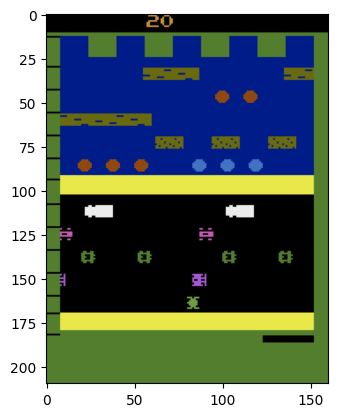

Total Steps: 290


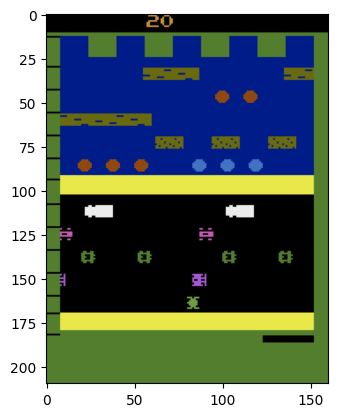

In [ ]:
# draw dqn playing game
state, info = env.reset()
state = np.array(state).squeeze()
done = False
step = 0
while not done:
    step += 1
    stacked_state = stack_frames(frame_stack, state)
    action = select_action(env, dqn, stacked_state, epsilon)
    next_state, reward, done, info, _ = env.step(action)
    next_state = np.array(next_state).squeeze()
    next_stacked_state = stack_frames(frame_stack, next_state)

    state = next_state
    stacked_state = next_stacked_state

    if done:
        break

    img = env.render()
    # store frame as pngs
    plt.imsave(f"./video1/frame_{step}.png", img)
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())
print(f"Total Steps: {step}")
env.close()

In [ ]:
import gymnasium as gym
import numpy as np

# Create Frogger environment
env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")

# Reset the environment
obs, info = env.reset()

# Check how many frames the agent cannot move
no_op_frames = 0
action = 2  # Move Up (example)

for i in range(200):  # Check the first 100 frames
    next_obs, reward, done, truncated, info = env.step(action)

    if reward != 0:  # If reward changes, movement is possible
        break

    no_op_frames += 1

print(f"Frogger cannot move for ~{no_op_frames} frames after reset.")


Frogger cannot move for ~200 frames after reset.


In [ ]:
# Training Model
# Train the model (adjust steps based on computing power)
model.learn(total_timesteps=50000)  # Train for 500k timesteps
model.save("pong_dqn_stablebaseline")

Logging to ./dqn_atari_tensorboard/DQN_5


In [ ]:
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward}, Std Dev: {std_reward}")

NameError: name 'evaluate_policy' is not defined

KeyboardInterrupt: 

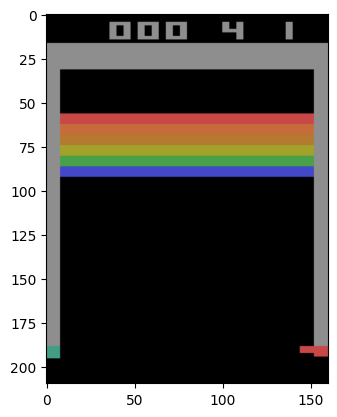

In [ ]:
obs, _ = env.reset()
for i in range(500):  # Play for 500 timesteps
    action, _ = model.predict(obs)  # Get action from model
    obs, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        obs, _ = env.reset()

    # Render & visualize
    img = env.render()
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())

env.close()

In [ ]:
import os
os.system("ffmpeg -i video1/frame_%01d.png -vcodec mpeg4 -y movie.mp4")


0